In [1]:
!pip install ultralytics
!pip install validators

In [2]:
import os
import urllib.request as ur
import numpy as np
import torch
import ultralytics
import cv2
from torchvision import transforms
from torchvision.models import efficientnet_v2_s as effnetv2
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

weight_detector = "/content/drive/MyDrive/yolov5-inat-shared"
weight_detector += "/runs-latest-yolov5x/train/exp/weights/best.pt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# ==================
# detection function
# ==================
def detect(
    image,                    # image
    model_detector="yolov5",  # detector model
    weight_detector=None,     # detector weight
    cls_custom=None,          # class to detect
    ci_custom=0.5             # confidence interval to accept detection
  ):

    # do checking for image
    url_image = ur.urlopen(image)
    arr = np.asarray(bytearray(url_image.read()), dtype=np.uint8)
    image = cv2.imdecode(arr, -1)
    if image is None:
        raise Exception(
            f"'cv2.imread()' could not read the image at path {image}."
        )

    # print the image
    %matplotlib inline
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

    # do checking for detector model
    if model_detector != "yolov5":
        raise ValueError("only 'yolov5' is supported for detector.")
    # do checking for detector weight
    if weight_detector == None:
        weight_default = "yolov5n"
        detector = torch.hub.load(
            "ultralytics/" + model_detector,
            weight_default
        )
        print(
            f"no weight is specified. "
            f"will use default weight '{weight_default}'."
        )
    else:
        detector = torch.hub.load(
            "ultralytics/" + model_detector,
            "custom",
            path=weight_detector,
            # source="local",  # this would cause an error
            force_reload=True
        )
        # # the following way to load model would cause an error
        # detector = torch.hub.load("ultralytics/" + model_detector, "yolov5x")
        # state_dict = torch.load(weight_detector)
        # detector.load_state_dict(state_dict, strict=False)
        print(
            f"a weight is specified and will be used.\n"
            f"that is '{weight_detector}'.\n"
        )

    # start detection
    output = detector(image)
    output.show()

    # print detection output analysis
    print(
        f"=========\n"
        f"inference\n"
        f"=========\n"
    )
    output = output.pandas().xyxy[0]
    i_step = 1
    print(
        f"inference step {i_step}:\n"
        f"detect all objects. as shown below.\n{output}\n"
    )

    output = output[output["name"] == cls_custom]
    i_step += 1
    print(
        f"inference step {i_step}:\n"
        f"select detected objects of specified class '{cls_custom}'. "
        f"as shown below.\n"
        f"{output}\n"
    )

    # print detection output further analysis
    if output.empty:
        raise Exception(
            f"no detected '{cls_custom}' "
            f"with confidence interval >= {ci_custom}."
        )
    else:
        if output.shape[0] == 1:
            print(
                f"only 1 detected '{cls_custom}' "
                f"with 'confidence interval >= {ci_custom}'. "
                f"as shown below.\n"
            )
        else:
            output = output.loc[[output["confidence"].idxmax()]]
            ci_high = round(output["confidence"].iloc[0], 2)
            print(
                f"note:\n"
                f"2 or more detected '{cls_custom}' "
                f"with specified confidence interval >= {ci_custom}.\n"
            )
            i_step += 1
            print(
                f"inference step {i_step}:\n"
                f"select the 1 detected '{cls_custom}' "
                f"with the highest confidence interval = {ci_high}. "
                f"as shown below.\n"
                f"{output}\n"
            )

        # get the bounding box and cut
        ymin, ymax = output["ymin"], output["ymax"]
        xmin, xmax = output["xmin"], output["xmax"]

        # crop the image according to the acquired bounding box
        image_cropped = image[int(ymin):int(ymax), int(xmin):int(xmax)]

        # show the cropped image
        i_step += 1
        print(
            f"inference step {i_step}\n"
            f"cropped the selected detected object. as shown below.\n"
        )

        plt.imshow(cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB))
        plt.show()

        # transform the cropped image
        """
        convert image to PIL Image;
        resize image to 224 x 224, as required by Efficient Net;
        convert image to PyTorch Tensor;
        normalise image, as required by Efficient Net.
        """
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        image_cropped = transform(image_cropped)
        image_cropped = image_cropped.unsqueeze(0)

        return image_cropped

In [5]:
# =======================
# classification function
# =======================
def classify(
    image_cropped,
    model_classifier="effnetv2",
    weight_classifier=None
):
    # checking for detector model
    if model_classifier != "effnetv2":
        raise ValueError("only 'effnetv2' is supported for detector.")
    # checking for detector weight
    if weight_classifier == None:
        classifier = effnetv2(pretrained=True)
    # start classification
    with torch.no_grad():
        output = torch.nn.functional.softmax(
            classifier(image_cropped),
            dim=1
        )

    # transform the output probability tensor into top classes
    utils = torch.hub.load(
        "NVIDIA/DeepLearningExamples:torchhub",
        "nvidia_convnets_processing_utils"
    )
    print("classification result:")
    output = utils.pick_n_best(predictions=output, n=5)

    return output

In [6]:
def inference(
    image,
    model_detector="yolov5",      # detector model
    weight_detector=None,         # detector weight
    model_classifier="effnetv2",  # classifier model
    weight_classifier=None,       # classifier weight
    cls_custom=None,              # class to detect
    ci_custom=0.1                 # confidence interval to accept detection
):
    # start detection
    image_cropped = detect(
        image=image,
        model_detector=model_detector,
        weight_detector=weight_detector,
        cls_custom=cls_custom,
        ci_custom=ci_custom
    )
    # start classification
    output = classify(
        image_cropped=image_cropped,
        model_classifier=model_classifier,
        weight_classifier=weight_classifier
    )
    return(output)

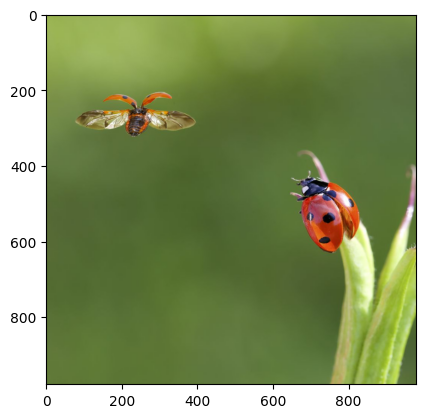

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-6-30 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 322 layers, 86254162 parameters, 0 gradients
Adding AutoShape... 


a weight is specified and will be used.
that is '/content/drive/MyDrive/yolov5-inat-shared/runs-latest-yolov5x/train/exp/weights/best.pt'.



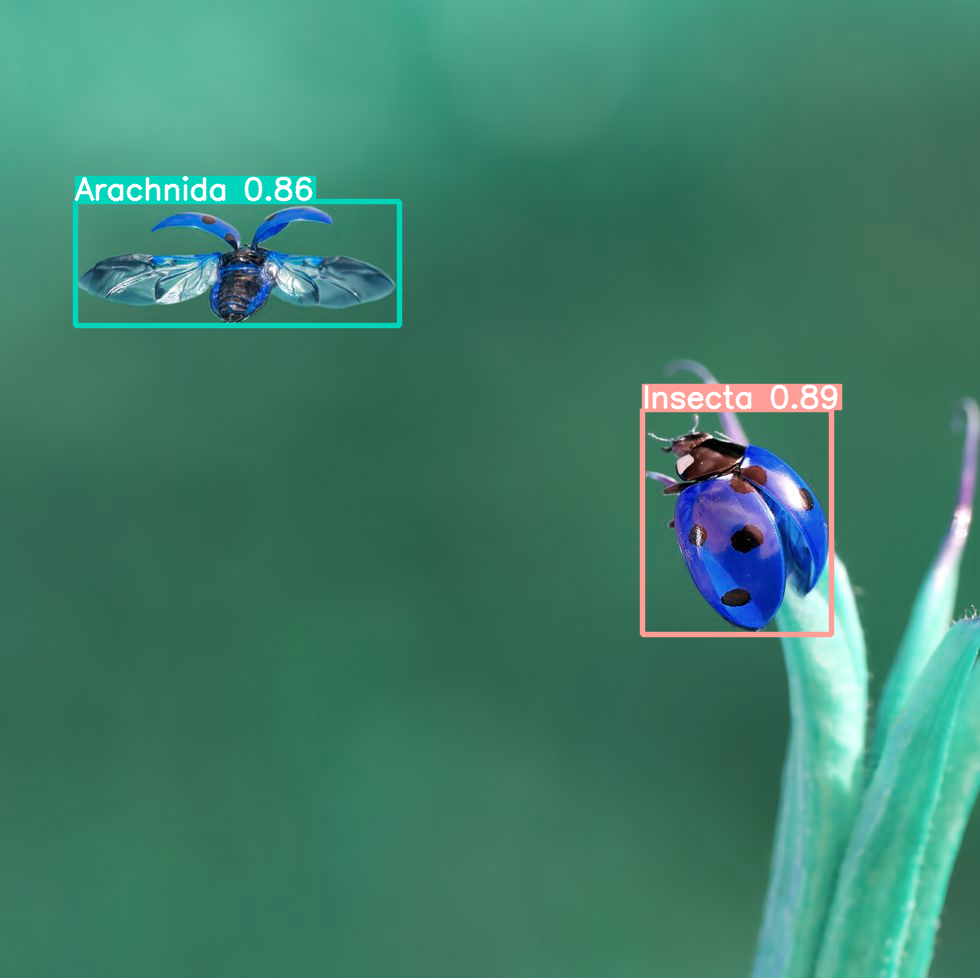

inference

inference step 1:
detect all objects. as shown below.
         xmin        ymin        xmax        ymax  confidence  class  \
0  642.537781  409.622101  831.894287  634.347595    0.891178      1   
1   75.655807  201.699066  399.484375  325.639526    0.859951      9   

        name  
0    Insecta  
1  Arachnida  

inference step 2:
select detected objects of specified class 'Insecta'. as shown below.
         xmin        ymin        xmax        ymax  confidence  class     name
0  642.537781  409.622101  831.894287  634.347595    0.891178      1  Insecta

only 1 detected 'Insecta' with 'confidence interval >= 0.1'. as shown below.

inference step 3
cropped the selected detected object. as shown below.



Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


classification result:
sample 0: [('water jug', '0.2%'), ('muzzle', '0.2%'), ('water bottle', '0.2%'), ('bannister, banister, balustrade, balusters, handrail', '0.2%'), ('oxygen mask', '0.2%')]


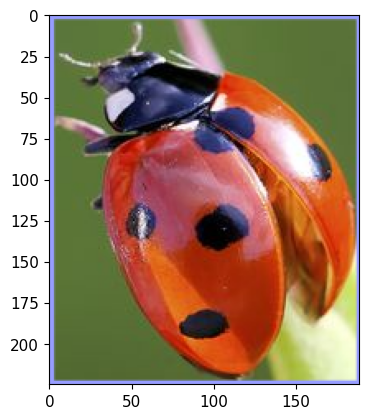

In [7]:
image = "https://hips.hearstapps.com/hmg-prod/images/amazing-insects-ladybugs"
image += "-587150149-1595940072.jpg?crop=0.763xw:1.00xh;0.0173xw,0&resize=980:*"

output = inference(
    image=image,
    model_detector="yolov5",
    weight_detector=weight_detector,
    model_classifier="effnetv2",
    weight_classifier=None,
    cls_custom="Insecta"
)